#  Evaluating Performance of Trained Conditioned Normalizing Flows for Climate Variable Downscaling
In this notebook, we will evaluate the performance of trained conditioned normalizing flows (CNFs) for downscaling climate variables. Conditioned normalizing flows are a powerful class of generative models that learn to map a simple distribution (e.g., Gaussian) to a complex target distribution by conditioning on additional information, such as low-resolution climate data. The main objective of this evaluation is to assess how well the trained CNF model can downscale climate variables, such as temperature, precipitation, or humidity, from coarse-resolution to fine-resolution spatial grids.


In [1]:
import torch
import numpy as np
import random
from models.architectures import srgan, srflow
import PIL
import os
import torchvision
from torchvision import transforms
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

# Dataset loading
from data import dataloading
from data.era5_temp_dataset import InverseMinMaxScaler

from os.path import exists, join
import matplotlib.pyplot as plt
from matplotlib import transforms
import timeit
import pdb
import argparse
import seaborn as sns

from utils.metrics import *

# %load_ext autoreload
# %autoreload 2

In [2]:
print('GPUs avail:', torch.cuda.device_count())

# Parse Settings
parser = argparse.ArgumentParser()

# train configs
parser.add_argument("--model", type=str, default="srflow",
                    help="Model you want to train.")
parser.add_argument("--modeltype", type=str, default="srflow",
                    help="Specify modeltype you would like to train [srflow, cdiff, srgan].")
parser.add_argument("--model_path", type=str, default="runs/",
                    help="Directory where models are saved.")
parser.add_argument("--modelname", type=str, default=None,
                    help="Sepcify modelname to be tested.")
parser.add_argument("--epochs", type=int, default=10000,
                    help="number of epochs")
parser.add_argument("--max_steps", type=int, default=2000000,
                    help="For training on a large dataset.")
parser.add_argument("--log_interval", type=int, default=100,
                    help="Interval in which results should be logged.")

# runtime configs
parser.add_argument("--visual", action="store_true",
                    help="Visualizing the samples at test time.")
parser.add_argument("--noscaletest", action="store_true",
                    help="Disable scale in coupling layers only at test time.")
parser.add_argument("--noscale", action="store_true",
                    help="Disable scale in coupling layers.")
parser.add_argument("--testmode", action="store_true",
                    help="Model run on test set.")
parser.add_argument("--train", action="store_true",
                    help="If model should be trained.")
parser.add_argument("--resume_training", action="store_true",
                    help="If training should be resumed.")
parser.add_argument("--constraint", type=str, default='scaddDS',
                    help="Physical Constraint to be applied during training.")                   

# hyperparameters
parser.add_argument("--nbits", type=int, default=8,
                    help="Images converted to n-bit representations.")
parser.add_argument("--s", type=int, default=2, help="Upscaling factor.")
parser.add_argument("--bsz", type=int, default=16, help="batch size")
parser.add_argument("--lr", type=float, default=0.0002, help="learning rate")
parser.add_argument("--filter_size", type=int, default=512, help="filter size NN in Affine Coupling Layer")
parser.add_argument("--L", type=int, default=3, help="# of levels")
parser.add_argument("--K", type=int, default=2,
                    help="# of flow steps, i.e. model depth")
parser.add_argument("--nb", type=int, default=16,
                    help="# of residual-in-residual blocks LR network.")
parser.add_argument("--condch", type=int, default=128//8,
                    help="# of residual-in-residual blocks in LR network.")

# data
parser.add_argument("--datadir", type=str, default="/home/mila/c/christina.winkler/scratch/data",
                    help="Dataset to train the model on.")
parser.add_argument("--trainset", type=str, default="era5-TCW", help='[era5-TCW, era5-T2M]')
parser.add_argument("--testset", type=str, default="era5-TCW", help="Specify test dataset")

args = parser.parse_args('')
config = vars(args)

GPUs avail: 1


### Load Data

In [3]:
# Load testset
train_loader,val_loader, test_loader, args = dataloading.load_data(args)

in_channels = next(iter(test_loader))[0].shape[1]
args.height, args.width = next(iter(test_loader))[0].shape[2], next(iter(test_loader))[0].shape[3]

args.device = "cuda"

Loading ERA5 TCW ...


### Exploratory Analysis

In [ ]:
# Assuming train_loader contains images with shape [N, C, H, W]
# N: batch size, C: channels, H: height, W: width
print(len(train_loader))
# Initialize lists to accumulate pixel values for each channel
all_pixels_per_channel = {0: [], 1: [], 2: []}  # Adjust the dictionary based on the number of channels

for idx, item in enumerate(train_loader):
    images = item[0]
    for channel in range(images.size(1)):
        all_pixels_per_channel[channel].append(images[:, channel, :, :].view(-1))

# Concatenate all pixel values for each channel
for channel in all_pixels_per_channel:
    all_pixels_per_channel[channel] = torch.cat(all_pixels_per_channel[channel])

2500


In [ ]:
# Plot histograms for each channel
colors = ['blue']  # Modify colors as needed for each channel
plt.figure(figsize=(15, 5))
for channel in range(len(colors)):
    plt.subplot(1, len(colors), channel + 1)
    plt.hist(all_pixels_per_channel[channel].numpy(), bins=50, color=colors[channel], alpha=0.7)
    plt.title(f'Pixel Value Distribution - Channel {channel}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Example DataLoader (replace this with your actual DataLoader)
# Assuming train_loader is already defined and loaded with your dataset

# Accumulate all pixel values
all_pixels = []

for images, _ in train_loader:
    images = images[0]
    all_pixels.append(images.view(-1))  # Flatten each batch and add to the list

# Concatenate all pixel values into a single tensor
all_pixels = torch.cat(all_pixels)

# Plot histogram of pixel values
plt.figure(figsize=(8, 6))
plt.hist(all_pixels.numpy(), bins=50, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Obtain Dataset Statistics

In [ ]:
# function to compute mean, std, min, max on whole dataset
def obtain_stats(train_loader):
    # Initialize mean and std
    mean = torch.zeros(1)
    std = torch.zeros(1)
    for idx, item in enumerate(train_loader):
        images,_ = item[0],item[1]
        std += ((images - mean.view(1, 1, 1, 1)) ** 2).mean(dim=[0, 2, 3])
        mean += images.mean(dim=[0, 2, 3])
    std = torch.sqrt(std/len(train_loader))
    mean /= len(train_loader)
    print(f'Std: {std}')
    print(f'Mean: {mean}')
    return mean, std

mean, std = obtain_stats(train_loader)

In [ ]:
# define scaler
def standard_scaler(x, min_value=None, max_value=None): # TODO
    # min_value = 0 if args.trainset == 'era5-TCW' else 315.91873
    # max_value = 100 if args.trainset == 'era5-TCW' else 241.22385
    x = x * (max_value - min_value) + min_value
    # return
    return x

def inv_scaler(x, min_value=None, max_value=None):
    # min_value = 0 if args.trainset == 'era5-TCW' else 315.91873
    # max_value = 100 if args.trainset == 'era5-TCW' else 241.22385
    x = x * (max_value - min_value) + min_value
    # return
    return x

### Experiment: Constraint placement
Comparing model with no constraint vs. multiplicative constraint at output layer

In [ ]:
# 2x watercontent mul with constraint at the end 
modelname = 'model_epoch_0_step_1000'
modelpath = '/home/mila/c/christina.winkler/clim-var-ds-cnf/runs/srflow_era5-TCW_mul_ constr_in_end__2024_06_03_17_35_33_2x/model_checkpoints/{}.tar'.format(modelname)

model = srflow.SRFlow((in_channels, args.height, args.width), args.filter_size, args.L, args.K,
                        args.bsz, args.s, 'mul', args.nb, args.condch, args.noscale, args.noscaletest)

params = sum(x.numel() for x in model.parameters() if x.requires_grad)
print('Nr of Trainable Params {}:  '.format(args.device), params)
model = model.to(args.device)
exp_name = "flow-{}-level-{}-k--constraint-{}".format(args.L, args.K, 'mul')
print(exp_name)

In [ ]:
ckpt = torch.load(modelpath, map_location='cuda:0')
model.load_state_dict(ckpt['model_state_dict'])

In [ ]:
# 2x watercontent with constraint after RDDB upscaling layers
# modelname = 'model_epoch_0_step_1000'
# modelpath = '/home/mila/c/christina.winkler/clim-var-ds-cnf/runs/srflow_era5-TCW_mul_ constr_in_end__2024_06_03_17_35_33_2x/model_checkpoints/{}.tar'.format(modelname)

# model = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K,
#                        args.bsz, args.s, 'mul', args.nb, args.condch, args.noscale, args.noscaletest)

In [ ]:
# ckpt = torch.load(modelpath, map_location='cuda:0')
# model.load_state_dict(ckpt['model_state_dict'])
# model.eval()

In [ ]:
# 2x watercontent with no constraint
# modelname = 'model_epoch_0_step_1000'
# modelpath = '/home/mila/c/christina.winkler/clim-var-ds-cnf/runs/srflow_era5-TCW_mul_ constr_in_end__2024_06_03_17_35_33_2x/model_checkpoints/{}.tar'.format(modelname)

# model = srflow.SRFlow((in_channels, height, width), args.filter_size, args.L, args.K,
#                        args.bsz, args.s, 'mul', args.nb, args.condch, args.noscale, args.noscaletest)

In [ ]:
# ckpt = torch.load(modelpath, map_location='cuda:0')
# model.load_state_dict(ckpt['model_state_dict'])
# model.eval()

### Helper Functions Evaluation

In [ ]:
def visualize_test(dataloader, model, exp_name, modelname, args, color='viridis'):
    savedir_viz = "experiments/{}_{}_{}_{}_{}x/snapshots/test/".format(exp_name, modelname, args.trainset, args.constraint, args.s)
    model.eval()
    
    return None

def metric_eval(dataloader, model, exp_name, modelname, args):
    metric_dict = {'rmse_mu0':[], 'mse_mu0':[], 'mae_mu0':[], 'rmse_mu05':[], 'mse_mu05':[], 'mae_mu05':[], 'rmse_mu08':[], 'mse_mu08':[], 'mae_mu08':[], 'rmse_mu1':[], 'mse_mu1':[], 'mae_mu1':[], 'crps': []}
    savedir_txt = 'experiments/{}_{}_{}/'.format(exp_name, modelname, args.trainset, args.constraint)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, item in enumerate(test_loader):

            y = item[0].to(args.device)
            x = item[1].to(args.device)

            y_unorm = item[2].to(args.device)
            x_unorm = item[3].unsqueeze(1).to(args.device)

            z, _ = model.forward(x_hr=y, xlr=x)
 
            # evaluate for different temperatures
            mu0, _, _ = model(xlr=x, reverse=True, eps=0)
            mu05, _, _ = model(xlr=x, reverse=True, eps=0.5)
            mu08, _, _ = model(xlr=x, reverse=True, eps=0.8)
            mu1, _, _ = model(xlr=x, reverse=True, eps=1.0)
            
#              imgs.append(inv_scaler(img))
            # TODO: add other metrics to dict
            # TODO: think about if also evaluate on unnormalized images
            crps_stack = torch.stack([mu0,mu05,mu08,mu1], dim=1)
            metric_dict['crps'].append(crps_ensemble(y_unorm, crps_stack))
    
    print(metric_dict)
    return metric_dict

### Metric Evaluation

In [ ]:
metric_eval(test_loader, model, exp_name, modelname, args)

### Visualize Predictions

### Scatter Plot (Predicted vs Target)
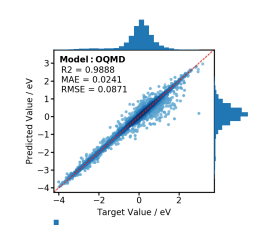

### Cumulative Distribution of  Residual Errors
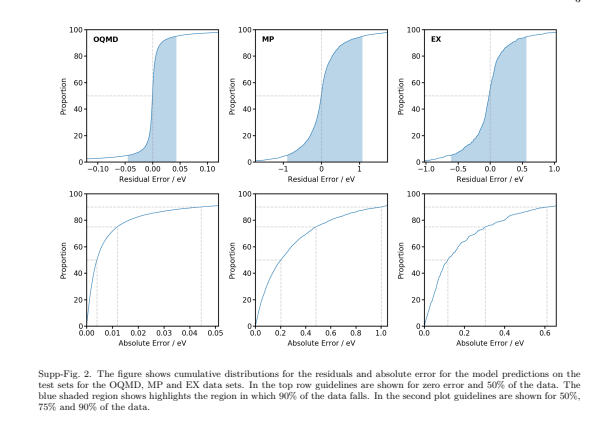